In [1]:
from AdventUtils_norvig_pytudes import *

# [Day 10](https://adventofcode.com/2024/day/10): Hoof It

Today's input is a topological map, with digits indicating the elevation of each terrain position.

In [2]:
topo = Grid(parse(10, digits))

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 54 strs:
────────────────────────────────────────────────────────────────────────────────────────────────────
567212105457654598212321234810354563543243210498768987
438903012368763285103410898901243432654158910347698876
327654789879100176501543487432382561783067681256580560
012789632101290125432692576545691070892101098545671421
231076541087389034898781987036788989787012147676542334
122345980196476945109650670129867875632103456789430945
034123670145565876212340548910058921945314967856321876
965014561234014212343211237432143430876465878947816543
...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 54 tuples:
────────────────────────────────────────────────────────────────────────────────────────────────────
(5, 6, 7, 2, 1, 2, 1, 0, 5, 4, 5, 7, 6, 5, 4, 5, 9, 8, 2, 1, 2, 3, 2, 1, 2, 3, 4, 8, 1, 0, 3,

### Part 1: What is the sum of the scores of all trailheads on your topographic map?

A **trailhead** is any position with elevation  0, and a **peak** is any position with elevation 9. The **score** of a trailhead is the number of peaks that can be reached by following a path where each step increases the elevation by exactly 1. All moves are in one of the four cardinal directions (north/south/east/west).

I'll keep a set of points on the frontier of possible paths, updating this set on each iteratation from 1 to 9, by looking at each point on the frontier and seeing which of the neighboring points `p` have the right elevation:

In [3]:
def score(topo: Grid, trailhead: Point) -> int:
    """How many peaks can be reached from this trailhead?"""
    frontier = {trailhead}
    for elevation in range(1, 10):
        frontier = {p for p in union(map(topo.neighbors, frontier))
                    if topo[p] == elevation}
    return len(frontier)

In [4]:
answer(10.1, 709, lambda:
       sum(score(topo, head) for head in topo.findall([0])))

Puzzle 10.1:   .0299 seconds, answer 709             ok

### Part 2: What is the sum of the ratings of all trailheads?

The **rating** of a trailhead is the number of distinct paths from the trailhead to a peak.

As in Part 1, I'll keep a frontier and update it on each iteration from 1 to 9, but this time the frontier will be a counter of `{position: count}` where the count indicates the number of paths to that position. On each iteration I'll look at each point `f` on the frontier and see which of the neighboring points `p` have the right elevation, and increment the counts for those points by the count for `f`. This approach is linear in the number of positions, whereas if I followed all possible paths depth-first there could be an exponential number of paths.

In [5]:
def rating(topo: Grid, trailhead: Point) -> int:
    """How many distinct paths are there from this trailhead to any peak?"""
    frontier = Counter({trailhead: 1})
    for elevation in range(1, 10):
        frontier = accumulate((p, frontier[f]) 
                              for f in frontier
                              for p in topo.neighbors(f) if topo[p] == elevation)
    return sum(frontier.values())

In [6]:
answer(10.2, 1326, lambda:
       sum(rating(topo, head) for head in topo.findall([0])))

Puzzle 10.2:   .0260 seconds, answer 1326            ok

Here's a visualization of the map:

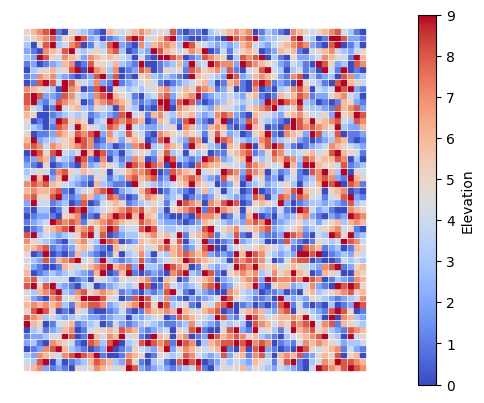

In [7]:
def plot_topo(topo: Grid):
    """Show the map with a colormap from blue to red."""
    plt.figure()
    scatter = plt.scatter(Xs(topo), Ys(topo), c=list(topo.values()), 
                          cmap='coolwarm', marker='s', s=12)
    plt.colorbar(scatter, label='Elevation')
    plt.axis('square')
    plt.axis('off')

plot_topo(topo)

# [Day 11](https://adventofcode.com/2024/day/11): Plutonian Pebbles

Today's narrative involves a straight line of stones, each of which has a number enscribed on it.  
The input is a single line of these numbers:

In [8]:
stones = the(parse(11, ints))

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 1 str:
────────────────────────────────────────────────────────────────────────────────────────────────────
41078 18 7 0 4785508 535256 8154 447
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 1 tuple:
────────────────────────────────────────────────────────────────────────────────────────────────────
(41078, 18, 7, 0, 4785508, 535256, 8154, 447)


### Part 1: How many stones will you have after blinking 25 times?

Every time you blink, the stones appear to change, according to these rules:
- A stone marked 0 changes to 1.
- Otherwise, a stone with an even number of digits splits into two stones, with the first and second halves of those digits.
- Otherwise, the stone's number is multiplied by 2024.

I'll define `blink` to simulate the effect of a given number of blinks,  
and `change_stone` to change a single stone, returning a list of whether  
one or two stones (the two stones computed by `split_stone`):

In [9]:
def blink(stones: Ints, blinks=25) -> List[int]:
    """Simulate the changes in the list of stones after blinking `blinks` times."""
    for _ in range(blinks):
        stones = append(map(change_stone, stones))
    return stones
    
def change_stone(stone: int) -> List[int]:
    """Change a single stone into one or two, according to the rules."""
    digits = str(stone)
    return ([1]                 if stone == 0           else
            split_stone(digits) if len(digits) % 2 == 0 else
            [stone * 2024])

def split_stone(digits: str) -> List[int]:
    """Split a stone into two halves."""
    half = len(digits) // 2
    return [int(digits[:half]), int(digits[half:])]

In [10]:
answer(11.1, 217443, lambda:
       len(blink(stones)))

Puzzle 11.1:   .2562 seconds, answer 217443          ok

### Part 2: How many stones would you have after blinking a total of 75 times?

It looks like the number of stones is roughly doubling every 1 or 2 blinks,  
so for 75 blinks we could have trillions of stones.  
I'd like something more efficient. I note that:
- Although the puzzle makes it clear that the stones are in a line, it turns out their position in the line is irrelevant.
- Because all the even-digit numbers get split in half, it seems like many small numbers will appear multiple times.  
  (In the given example, after 6 blinks the number 2 appears 4 times.)
- Therefore, I'll keep a Counter of stones rather than a list of stones.

In [11]:
def blink2(stones: Ints, blinks=25) -> Counter:
    """Simulate the changes after blinking `blinks` times and return a Counter of stones."""
    counts = Counter(stones)
    for _ in range(blinks):
        counts = accumulate((s, counts[stone]) 
                            for stone in counts 
                            for s in change_stone(stone))
    return counts

Now we can re-run Part 1 (it should be slightly faster), and run Part 2 without fear of having trillion-element lists:

In [12]:
answer(11.1, 217443, lambda:
       total(blink2(stones, 25)))

Puzzle 11.1:   .0057 seconds, answer 217443          ok

In [13]:
answer(11.2, 257246536026785, lambda:
       total(blink2(stones, 75)))

Puzzle 11.2:   .1825 seconds, answer 257246536026785 ok

# [Day 12](https://adventofcode.com/2024/day/12): Garden Groups

Today's input is yet another 2D map. 
This one depicts different garden plots on a farm, each plot planted with a crop, indicated by a letter  
(maybe "I" is iceberg lettuce and "U" is udo, and so on):

In [14]:
farm = Grid(parse(12))

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 140 strs:
────────────────────────────────────────────────────────────────────────────────────────────────────
OBBBBLLLLLLVVVVVVVVVVVVVVMMMMMMMMMMMMMMMMMMMMMJJJJJJJJJJOOOOOOORRRRRRRRRRRRRRRRRRRRXXXXXXXXXXXXX ...
OBBBBBLLLLLLVVVVVVVVVVVVVVVVSSMMVVVMVVMMMMMMMMLJJJJJJJJJOOOORRRRRRRRRRRRRRRRRRRRRRRXXXXXXXXXXXXX ...
OBBBBBLLLLKKKKKVVVVVVVVVVFVSSSSMMMVVVVVMMMMMMMLLJJJJJJJJJOOOOORRRRRRRRRRRRRRRRRRRRDDDXXXXXXXXXXX ...
OJXXXJJLLLLKKVVVVVVVVVVVVFVSSSSSMVVVVVVMMMMMMMLLJJJJJJJJOOOOOQQRRRRRRRRRRRRRRRRRRRDDPPXXXXXXXXXX ...
OJXXXJJJLLKKWVVVVVVVVVVFFFSSSSSMMVZVVVVVMMMMMLLLJJJJJGGGOOOOQQQRWRRRRRRRRRRRRRRRRRRRPYXXXXXXXXXX ...
JJXXJJJJJJJJVVVVVVGGGFFFFFSSSSSSMMVVRWWLLMMMLLLLJJJJJJGGOGOQQQQQWRRRRRRRRRRRRIRPRRPPPPPPXXXXXXXX ...
JJJJJJJJJJJJJJJVVGGGGFFFFFFFFSSSMMMMWWWWLLMMLLLLLLJJJGGGGGGQQQQQQRRRRRRRRRIRRIPPPPPPPPPPXXXXXXXX ...
JJJJJJJJJJJJZZZZGGGGGGGGGGGFSSSMMMMMWWWMWLLLLLLLLLJLGGGGGGGGQQQQQQ

### Part 1: What is the total price of fencing all regions on your map?
We are asked to calculate the cost of putting fences around each **region** (a region is a set of plots with the same crop that abut each other horizontally or vertically).
The price of the fence for a region is defined as the product of the region's area and its perimeter.
If we represent a region as a set of (x, y) points, then the area is easy: it is just the number of points.
The perimeter length can be computed by, for each plot point in the region, looking at each of the four directions and counting cases where the adjacent plot in that direction is not in the region.

In [15]:
Region = Set[Point]
region_area = len

def fence_price(farm: Grid) -> int:
    """Total price of fences for all the regions in the farm."""
    return sum(map(region_price, regions(farm)))

def region_price(region) -> int: return region_area(region) * perimeter_length(region)

def perimeter_length(region: Region) -> int:
    """The number of sides on the perimeter of the region."""
    return quantify(add2(plot, d) not in region for plot in region for d in directions4)

To find all the regions I'll start at a point and do a [flood fill](https://en.wikipedia.org/wiki/Flood_fill) to neighboring points with the same region letter, keeping track of points that have already been found so as to not duplicate them.
The function `regions` iterates over all points to make sure it finds every region, and `flood_fill` recursively expands to all points that neighbor `p` and have the same crop (letter).
This function mutates the set `already_found` as it goes (and also mutates the `region` it is building up).

In [16]:
def regions(farm: Grid) -> List[Region]:
    """Find all the regions in the farm."""
    already_found = set() # Set of plots already accounted for
    return [flood_fill(p, farm, set(), already_found) 
            for p in farm if p not in already_found]

def flood_fill(p: Point, grid: Grid, region: set, already_found: set) -> set:
    """Starting at point p, recursively add all neighboring points to `region`, keeping track of `already_found`."""
    if p not in already_found:
        region.add(p)
        already_found.add(p)
        for p2 in grid.neighbors(p):
            if farm[p2] == farm[p]:
                flood_fill(p2, grid, region, already_found)
    return region

In [17]:
answer(12.1, 1546338, lambda:
       fence_price(farm))

Puzzle 12.1:   .2111 seconds, answer 1546338         ok

### Part 2: What is the new total price of fencing all regions on your map, with the bulk discount?

In Part 2 we get a bulk discount on the fencing; we only need to pay for the number of straight line sides on the perimeter, not the total length of the perimeter.
For example, a 10 x 10 square has perimeter 40, but has only 4 sides; that's a 90% discount!

A good idea is to start with the perimeter length and subtract one for every case in which a points has an edge in one direction (e.g., an edge to the North) and also has a neighbor with the same edge. To be precise, I'll look for four cases:

- A point with an edge to the North whose neighbor to the East also has an edge to the North
- A point with an edge to the East whose neighbor to the South also has an edge to the East
- A point with an edge to the South whose neighbor to the West also has an edge to the South
- A point with an edge to the West whose neighbor to the North also has an edge to the West

Here are two diagrams of two regions with "`X`" and "`W`" crops with a "`-`" marking each place where a perimeter piece would be subtracted.

```
 .X-...    .-------..
 -X-.X-    .WWWWWWWW-
 -XXXX-    -WWWWWWWW-
 ..XXX.    -WWWWWWWW.
 ...--.    ..-------.
```

I'll parameterize `fence_price` to take a `region_price` parameter, and show that the change is backwards compatible to Part 1:

In [18]:
def fence_price(farm: Grid, region_price=region_price) -> int:
    """Total price of fences for all the regions in the farm, given the price function for a region."""
    return sum(map(region_price, regions(farm)))

def discount_region_price(region) -> int: return region_area(region) * region_sides(region)
    
def region_sides(region):
    """How many straight-line sides does this region have?"""
    def has_edge(p: Point, d: Vector): return p in region and add2(p, d) not in region
    def neighbor(p: Point, d: Vector): return add2(p, make_turn(d, 'R'))
    subtract = quantify(has_edge(p, d) and has_edge(neighbor(p, d), d)
                        for p in region
                        for d in directions4)
    return perimeter_length(region) - subtract

In [19]:
answer(12.1, 1546338, lambda:
       fence_price(farm))

Puzzle 12.1:   .1342 seconds, answer 1546338         ok

In [20]:
answer(12.2, 978590, lambda: 
       fence_price(farm, discount_region_price))

Puzzle 12.2:   .2918 seconds, answer 978590          ok

# [Day 13](https://adventofcode.com/2024/day/13): Claw Contraption

Today's puzzle involves arcade claw machines.
Each input paragraph describes a machine with two buttons, **A** and **B**;
every push of a button moves the claw a specified amount in the X and Y directions.
The prize is at a specified location.
We can parse the input by defining a `parse_claw` function and a `Claw` datatype to represent a claw machine:

In [21]:
from collections import namedtuple

Claw = namedtuple('Claw', 'A, B, Prize') # A claw machine

def parse_claw(text: str) -> Claw:
    """Parse a description into a Claw object."""
    ax, ay, bx, by, px, py = ints(text)
    return Claw((ax, ay), (bx, by), (px, py))
    
claws = parse(13, parse_claw, sections=paragraphs)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 1279 strs:
────────────────────────────────────────────────────────────────────────────────────────────────────
Button A: X+92, Y+24
Button B: X+13, Y+94
Prize: X=8901, Y=8574

Button A: X+52, Y+13
Button B: X+27, Y+72
Prize: X=18587, Y=299

...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 320 Claws:
────────────────────────────────────────────────────────────────────────────────────────────────────
Claw(A=(92, 24), B=(13, 94), Prize=(8901, 8574))
Claw(A=(52, 13), B=(27, 72), Prize=(18587, 299))
Claw(A=(45, 21), B=(34, 56), Prize=(12602, 14690))
Claw(A=(78, 53), B=(14, 35), Prize=(2228, 2432))
Claw(A=(77, 16), B=(13, 79), Prize=(16314, 19562))
Claw(A=(27, 72), B=(57, 11), Prize=(16094, 14389))
Claw(A=(43, 77), B=(51, 13), Prize=(15606, 16498))
Claw(A=(79, 45), B=(41, 99), Prize=(5535, 7389))
.

### Part 1: What is the fewest tokens you would have to spend to win as many prizes as possible?
We are told that for some machines it is possible to reach the prize and others it is impossible.
We are also told that you need to spend 3 tokens to press the **A** button and 1 token to press the **B** button.
There is a hint that no button will need to be pushed more than 100 times.
It is usually a good idea to accept the hint, so I will do the following:

- Exhaustively try from every number from 0 to 100 presses of the **A** button.
- For each number, figure out what the resulting position of the claw would be after those presses.
- Calculate how many presses of the **B** button would be required to get to the prize's X location.
- If the number of presses is an integer, and would also arrive at the prize's Y location, then yield that solution.
- Out of these solutions, the cheapest solution is the one that needs the fewest tokens.
- (If there are no solutions, `cheapest_solution` will return 0, whcih is convenient for adding the results up.)

In [22]:
def solve_claw(claw: Claw, limit=100) -> Iterable[Tuple[int, int]]:
    """All possible (A-presses, B-presses) solutions to reach the prize on this machine."""
    A, B, Prize = claw
    for Apresses in range(limit + 1):
        pos = mul(A, Apresses)
        if X_(pos) > X_(Prize) or Y_(pos) > Y_(Prize):
            return
        diff = sub2(Prize, pos)
        Bpresses = X_(diff) / X_(B)
        if Bpresses.is_integer() and Bpresses * Y_(B) == Y_(diff):
            yield (Apresses, int(Bpresses))

def cheapest_solution(claw: Claw) -> int: 
    """The minimum cost out of every possible solution to this claw machine."""
    return min((3 * A + 1 * B for (A, B) in solve_claw(claw)), default=0)

In [23]:
answer(13.1, 36954, lambda:
       sum(map(cheapest_solution, claws)))

Puzzle 13.1:   .1212 seconds, answer 36954           ok

### Part 2: What is the fewest tokens you would have to spend to win as many prizes as possible, now?
In Part 2, we discover that the prize is actually much farther away, by 10,000,000,000,000 (ten trillion) steps in both the X and Y coordinates.
Theoretically, we could still use solve_claw with a bigger limit, but that would take a long time.
Instead I can solve each claw machine mathematically rather than by trial and error.
In general, two linear equations in two unknowns can have zero solutions (if the lines are parallel), an infinite number of solutions (if the lines are the same), or exactly one solution (otherwise).
The further constraint that *A* and *B* have to be non-negative integers may rule out some of these solutions, but mostly we are looking for the one point where two lines intersect.
I defined `solve_claw` to yield multiple solutions, but let's see how many solutions each claw machine yields:

In [24]:
Counter(quantify(solve_claw(c)) for c in claws)

Counter({1: 177, 0: 143})

So, what is the intersection point of two lines?
Given the two equations over the two variables *a* and *b*:

p * a + q * b = r  
s * a + t * b = u

The solution is:

a = (r * t - q * u) / (p * t - q * s)  
b = (r * s - p * u) / (q * s - p * t)

So we can rewrite `solve_claw` to use this:

In [25]:
def solve_claw(claw: Claw) -> Iterable[Tuple[int, int]]:
    """All possible (A-presses, B-presses) solutions to reach the prize on this machine."""
    ((p, s), (q, t), (r, u)) = claw
    a = (r * t - q * u) / (p * t - q * s)
    b = (r * s - p * u) / (q * s - p * t)
    if a >= 0 and b >= 0 and a.is_integer() and b.is_integer():
        yield (int(a), int(b))

We'll need a function to move the claws further away, then we're ready to answer Part 2:

In [26]:
def move_prize(claw, delta=(10**13, 10**13)) -> Claw:
    """Move the claw's prize by the given displacement, delta."""
    return claw._replace(Prize=(add(claw.Prize, delta)))

In [27]:
answer(13.2, 79352015273424, lambda:
       sum(cheapest_solution(move_prize(claw)) for claw in claws))

Puzzle 13.2:   .0015 seconds, answer 79352015273424  ok

# [Day 14](https://adventofcode.com/2024/day/14): Restroom Redoubt

Today's narratives involve robots roaming around a restroom.
Each line of the input describes a robot's position and velocity in two dimensions:

In [28]:
robots = parse(14, ints)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 500 strs:
────────────────────────────────────────────────────────────────────────────────────────────────────
p=43,30 v=73,-79
p=20,21 v=-72,96
p=24,57 v=-95,97
p=29,86 v=-19,83
p=30,80 v=-91,-16
p=45,19 v=30,-89
p=12,29 v=45,-46
p=86,51 v=-31,8
...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 500 tuples:
────────────────────────────────────────────────────────────────────────────────────────────────────
(43, 30, 73, -79)
(20, 21, -72, 96)
(24, 57, -95, 97)
(29, 86, -19, 83)
(30, 80, -91, -16)
(45, 19, 30, -89)
(12, 29, 45, -46)
(86, 51, -31, 8)
...


In [29]:
def robot_dance(robots, steps=100, width=101, height=103) -> List[Point]:
    """Move each robot for `steps` number of steps."""
    return [((x + steps * dx) % width, (y + steps * dy) % height)
            for (x, y, dx, dy) in robots]

def quadrant_counts(positions, w=101//2, h=103//2) -> Counter:
    """How many robots are in each quadrant? Ignore robots exactly in the middle."""
    return Counter((sign(x - w), sign(y - h)) 
                   for (x, y) in positions if x != w and y != h)

def safety_factor(robots) -> int:
    """The product of the counts in each of the four quadrants."""
    return prod(quadrant_counts(robot_dance(robots)).values())

In [30]:
answer(14.1, 216772608, lambda:
       safety_factor(robots))

Puzzle 14.1:   .0007 seconds, answer 216772608       ok

In [31]:
robots = parse(14, ints)

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 500 strs:
────────────────────────────────────────────────────────────────────────────────────────────────────
p=43,30 v=73,-79
p=20,21 v=-72,96
p=24,57 v=-95,97
p=29,86 v=-19,83
p=30,80 v=-91,-16
p=45,19 v=30,-89
p=12,29 v=45,-46
p=86,51 v=-31,8
...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 500 tuples:
────────────────────────────────────────────────────────────────────────────────────────────────────
(43, 30, 73, -79)
(20, 21, -72, 96)
(24, 57, -95, 97)
(29, 86, -19, 83)
(30, 80, -91, -16)
(45, 19, 30, -89)
(12, 29, 45, -46)
(86, 51, -31, 8)
...


### Part 1: What will the safety factor be after exactly 100 seconds have elapsed?
Each second the robots move according to their velocity, and they wrap around when they reach the edge of their world, which has width 101 and height 103.
They can pass through each other.
We're asked to figure out where they are after 100 seconds.
I can see that it is not necessary to step the robots each time step; we can just multiply their velocity by time, add it to their initial position, and then take the result modulo the width or height.
That's done in `robot_dance`.
We're asked to figure out how many robots end up in each **quadrant**.
There are four quadrants, but a robot that is exactly on a middle line, either horizontally or vertically, doesn't count).
Finally, the **safety factor** is the product of the count of robots in each quadrant.

In [32]:
def robot_dance(robots, steps=100, width=101, height=103) -> List[Point]:
    """Move each robot for `steps` number of steps."""
    return [((x + steps * dx) % width, (y + steps * dy) % height)
            for (x, y, dx, dy) in robots]

def quadrant_counts(positions, w=101//2, h=103//2) -> Counter:
    """How many robots are in each quadrant? Ignore robots exactly in the middle."""
    return Counter((sign(x - w), sign(y - h)) 
                   for (x, y) in positions if x != w and y != h)

def safety_factor(robots) -> int:
    """The product of the counts in each of the four quadrants."""
    return prod(quadrant_counts(robot_dance(robots)).values())

In [33]:
answer(14.1, 216772608, lambda:
       safety_factor(robots))

Puzzle 14.1:   .0004 seconds, answer 216772608       ok

### Part 2: What is the fewest number of seconds that must elapse for the robots to display a picture of a Christmas Tree?

They ask the very vague question of when a picture emerges.
They gave the hint that "*very rarely, most of the robots should arrange themselves into a picture of a Christmas tree*".
Since I don't know exactly how to specify a Christmas tree picture, I see two options:

- I could build an animation, and watch as each frame is displayed, stopping when I see something that looks like a tree.
- The phrase "*most of the robots should arrange themselves*" suggests that most of the robots are in one area. I could check for that.

I'll try the animation first.
Google and Stack overflow led me to the `matplotlib.animation.FuncAnimation` function:

In [34]:
import matplotlib.animation

def animate_robots(robots, times: Ints):
    """Animate the robot dance over the given time steps."""
    plt.rcParams["animation.html"] = "jshtml"
    plt.rcParams['figure.dpi'] = 150  
    plt.ioff()
    fig, ax = plt.subplots()
    def animate(t: int):
        points = robot_dance(robots, t)
        plt.cla()
        ax.yaxis.set_inverted(True)
        plt.plot(*T(points), 'o')
        plt.title(f'{t} seconds')
    return matplotlib.animation.FuncAnimation(fig, animate, frames=times)

Here's what it looks like:

In [35]:
animate_robots(robots, range(3))

I looked at hundreds of frames, but no Christmas tree emerged.

So, on to the second idea.
If the hint had mentioned "*all of the robots*", I would look for a frame with the minimum bounding box.
But for "*most of the robots*", I'll look for a frame that minimizes the mean distance from the centroid.
I'll use `taxi_distance`; if that doesn't work I'll try regular `distance`:

In [36]:
def mean_distance_to_centroid(points, distance=taxi_distance) -> float:
    """The mean of each point's distance to the centroid."""
    centroid = (mean(Xs(points)), mean(Ys(points)))
    return mean(distance(p, centroid) for p in points)

def most_clustered_time(robots, times=range(10_000)) -> int:
    """Out of all the given time steps, the one that has the robots clustered closest together."""
    return min(times, key=lambda t: mean_distance_to_centroid(robot_dance(robots, t)))

In [37]:
t = most_clustered_time(robots)
animate_robots(robots, [t])

In [38]:
answer(14.2, 6888, lambda:
       most_clustered_time(robots, range(7000)))

Puzzle 14.2:  7.0630 seconds, answer 6888            ok

# [Day 15](https://adventofcode.com/2024/day/15): Warehouse Woes

Today's input is in two sections: the first section is a grid map describing a warehouse with walls (`#`) and boxes (`O`) and one robot (`@`).
The second part is a set of instructions for how the robot moves (arrows).
I'll parse the two sections as paragraphs, then parse each paragraph:

In [39]:
warehouse_woes = parse(15, sections=paragraphs)
warehouse = Grid(parse(warehouse_woes[0]))
arrows    = cat(parse(warehouse_woes[1]))

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 71 strs:
────────────────────────────────────────────────────────────────────────────────────────────────────
##################################################
##OO............#..........O.O..O.O.....O..O..O..#
#O...#.O.O.O....#OO.#O....#.........O.#..........#
#O....O..O.OO.OOO.#.....O#.....#..#O.OO..........#
#.O#OOO...O............O##......#..O..O......O..##
#......#....#...OO....O.#OO..O.OO.OO.O#........#.#
#...O...##.....OO...O..#...O....O....O.....O...O.#
##.O.#...##....O..............#....O....O.O..O#.O#
...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 2 strs:
────────────────────────────────────────────────────────────────────────────────────────────────────
##################################################
##OO............#..........O.O..O.O.....O..O. ...
>v^>^^^^^>>^^vvvv<v<<v^^^<>

### Part 1: What is the sum of all boxes' GPS coordinates after moving?

The robot attempts to follow each instruction arrow (for example, moving East when the arrow is `>`).
The robot is strong enough to push a line of any number of boxes sitting in front of it; that's its job.
However, if a push is blocked by a wall, then neither the robot nor any boxes will move.

The **GPS coordinate** of a box at (*x, y*) is *x + 100y*.

I'll implement `obey_arrows` to make the arrow moves on a copy of the warehouse.
For each arrow it finds all boxes that might move (and the robot) with `moveables`, then `make_movement` checks if they would bump into a wall, and if not, they all move.

In [40]:
def gps_coordinate(box: Point) -> int: return X_(box) + 100 * Y_(box)

def obey_arrows(warehouse: Grid, arrows: str) -> Grid:
    """Return a grid in which the robot has followed `arrows`, pushing boxes around."""
    grid = warehouse.copy()
    robot_pos = the(grid.findall('@'))
    for arrow in arrows:
        dir = arrow_direction[arrow]
        robot_and_boxes = moveables(grid, robot_pos, dir)
        if make_movement(grid, robot_and_boxes, dir):
            robot_pos = add2(robot_pos, dir)
    return grid

def moveables(grid, start: Point, dir: Vector) -> List[Point]:
    """The positions of moveable things (the robot and maybe boxes) going in direction `dir` from the `start`."""
    def moveable(pos): return grid[pos] in ('@', 'O')
    return list(takewhile(moveable, grid.follow_line(start, dir)))

def make_movement(grid, to_move: List[Point], dir: Vector) -> bool:
    """Try to move the objects in the `to_move` positions in direction `dir`; return True if they move."""
    if grid[add2(to_move[-1], dir)] == '#':
        return False
    else:
        for p in reversed(to_move):
            grid[add2(p, dir)] = grid[p]
            grid[p] = '.'
        return True

In [41]:
answer(15.1, 1568399, lambda:
       sum(map(gps_coordinate, obey_arrows(warehouse, arrows).findall('O'))))

Puzzle 15.1:   .0922 seconds, answer 1568399         ok

### Part 2: What is the sum of all boxes' final GPS coordinates on the double-wide grid?

In Part 2, there is another warehouse that is similar to the first, but twice as wide.
Each position in the original warehouse is replaced by two copies of the contents, except that the robot is replaced by `@.` and a box, `O`, is replaced by `[]`, indicating the two halves of a double-wide box.
The rules for movement and pushing are the same, except that when the robot is moving North or South and is pushing a box, that box, since it is two positions wide, can push *two* boxes if they are lined up right.
(Presumably, those two boxes could then push three boxes in the next row, and so on, although the problem description did not explicitly specify that).
Finally, the GPS coordinates are taken for the `[` part of the box.

So this is mostly the same as Part 1, but the criteria of what to move is different.
Here are the changes I'll make:

- I'll need to make the double-wide grid, by applying `doublewide` to the original text to get `warehouse2`.
- I'll redefine `make_movement` to check for a wall in front of *any* of the boxes, not just the last one, and to move them all in one update, rather than one at a time.
- I'll redefine `moveables` to deal with either regular or double-wide boxes (but not both in one maze).

In [42]:
def doublewide(text: str) -> str:
    """Make the grid twice as wide."""
    return text.replace('#', '##').replace('O', '[]').replace('.', '..').replace('@', '@.')
    
warehouse2 = Grid(parse(doublewide(warehouse_woes[0])))

def make_movement(grid, to_move: Collection[Point], dir: Vector) -> bool:
    """Try to move the objects in the `to_move` positions in direction `dir`; return True if they move."""
    def go(p): return add2(p, dir)
    if any(grid[go(p)] == '#' for p in to_move):
        return False
    else:
        updates = {go(p): grid[p] for p in to_move}
        grid.update({p: '.' for p in to_move})
        grid.update(updates)
        return True

def moveables(grid, start_pos, dir) -> Set[Point]:
    """The positions of moveable things (robot and maybe boxes) going in direction from the start.""" 
    ahead = add2(start_pos, dir)
    if dir in (East, West) or grid[ahead] == 'O': # Single line push
        def moveable(pos): return grid[pos] in ('@', 'O', '[', ']')
        return set(takewhile(moveable, grid.follow_line(start_pos, dir)))
    else: # Potential non-linear push
        results = {start_pos}
        if grid[ahead] in ('[', ']'): results |= moveables(grid, ahead, dir) 
        if grid[ahead] == '[':        results |= moveables(grid, add2(ahead, East), dir)
        if grid[ahead] == ']':        results |= moveables(grid, add2(ahead, West), dir)
        return results

In [43]:
answer(15.2, 1575877, lambda:
       sum(map(gps_coordinate, obey_arrows(warehouse2, arrows).findall('['))))

Puzzle 15.2:   .1244 seconds, answer 1575877         ok

In [44]:
warehouse_woes = parse(15, sections=paragraphs)
warehouse = Grid(parse(warehouse_woes[0]))
arrows    = cat(parse(warehouse_woes[1]))

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 71 strs:
────────────────────────────────────────────────────────────────────────────────────────────────────
##################################################
##OO............#..........O.O..O.O.....O..O..O..#
#O...#.O.O.O....#OO.#O....#.........O.#..........#
#O....O..O.OO.OOO.#.....O#.....#..#O.OO..........#
#.O#OOO...O............O##......#..O..O......O..##
#......#....#...OO....O.#OO..O.OO.OO.O#........#.#
#...O...##.....OO...O..#...O....O....O.....O...O.#
##.O.#...##....O..............#....O....O.O..O#.O#
...
────────────────────────────────────────────────────────────────────────────────────────────────────
Parsed representation ➜ 2 strs:
────────────────────────────────────────────────────────────────────────────────────────────────────
##################################################
##OO............#..........O.O..O.O.....O..O. ...
>v^>^^^^^>>^^vvvv<v<<v^^^<>

In [45]:
def gps_coordinate(box: Point) -> int: return X_(box) + 100 * Y_(box)

def obey_arrows(warehouse: Grid, arrows: str) -> Grid:
    """Return a grid in which the robot has followed `arrows`, pushing boxes around."""
    grid = warehouse.copy()
    robot_pos = the(grid.findall('@'))
    for arrow in arrows:
        dir = arrow_direction[arrow]
        robot_and_boxes = moveables(grid, robot_pos, dir)
        if make_movement(grid, robot_and_boxes, dir):
            robot_pos = add2(robot_pos, dir)
    return grid

def moveables(grid, start: Point, dir: Vector) -> List[Point]:
    """The positions of moveable things (the robot and maybe boxes) going in direction `dir` from the `start`."""
    def moveable(pos): return grid[pos] in ('@', 'O')
    return list(takewhile(moveable, grid.follow_line(start, dir)))

def make_movement(grid, to_move: List[Point], dir: Vector) -> bool:
    """Try to move the objects in the `to_move` positions in direction `dir`; return True if they move."""
    if grid[add2(to_move[-1], dir)] == '#':
        return False
    else:
        for p in reversed(to_move):
            grid[add2(p, dir)] = grid[p]
            grid[p] = '.'
        return True

In [46]:
answer(15.1, 1568399, lambda:
       sum(map(gps_coordinate, obey_arrows(warehouse, arrows).findall('O'))))

Puzzle 15.1:   .0933 seconds, answer 1568399         ok

In [47]:
def doublewide(text: str) -> str:
    """Make the grid twice as wide."""
    return text.replace('#', '##').replace('O', '[]').replace('.', '..').replace('@', '@.')
    
warehouse2 = Grid(parse(doublewide(warehouse_woes[0])))

def make_movement(grid, to_move: Collection[Point], dir: Vector) -> bool:
    """Try to move the objects in the `to_move` positions in direction `dir`; return True if they move."""
    def go(p): return add2(p, dir)
    if any(grid[go(p)] == '#' for p in to_move):
        return False
    else:
        updates = {go(p): grid[p] for p in to_move}
        grid.update({p: '.' for p in to_move})
        grid.update(updates)
        return True

def moveables(grid, start_pos, dir) -> Set[Point]:
    """The positions of moveable things (robot and maybe boxes) going in direction from the start.""" 
    ahead = add2(start_pos, dir)
    if dir in (East, West) or grid[ahead] == 'O': # Single line push
        def moveable(pos): return grid[pos] in ('@', 'O', '[', ']')
        return set(takewhile(moveable, grid.follow_line(start_pos, dir)))
    else: # Potential non-linear push
        results = {start_pos}
        if grid[ahead] in ('[', ']'): results |= moveables(grid, ahead, dir) 
        if grid[ahead] == '[':        results |= moveables(grid, add2(ahead, East), dir)
        if grid[ahead] == ']':        results |= moveables(grid, add2(ahead, West), dir)
        return results

In [48]:
answer(15.2, 1575877, lambda:
       sum(map(gps_coordinate, obey_arrows(warehouse2, arrows).findall('['))))

Puzzle 15.2:   .1297 seconds, answer 1575877         ok

# [Day 16](https://adventofcode.com/2024/day/16): Reindeer Maze

Today's input is yet another 2D grid, this one a maze that reindeer run through:

In [49]:
maze = Grid(parse(16))

────────────────────────────────────────────────────────────────────────────────────────────────────
Puzzle input ➜ 141 strs:
────────────────────────────────────────────────────────────────────────────────────────────────────
################################################################################################ ...
#.......#...#.#.........#...#.........#.......#.................#...........#...............#... ...
###.#.#.#.#.#.#.###.###.#.###.#.#######.#.###.#.#.###.#########.#.#####.#.#.#.###.#.###.#.#.#### ...
#.....#...#.#.....#.......................#.#.#.....#.#.....#.#.#.#.....#.#.#.#.#.#...#.#.#..... ...
#.#.#.#####.#.#####.#.#.#####.#########.#.#.#.#.#.#.###.###.#.#.#.#.#####.#.#.#.#.###.#.#.#####. ...
#.#.....#...#.#.....#.#.....#.#...#.......#...#...#.......#.#...#.#.....#...#.#...#...#...#...#. ...
#.#.#.###.###.#.#####.#####.#.#.#.#.###.###.###.#.#########.#####.#####.#.###.#.###.#######.#.#. ...
#.#...........................#.#...#.....#.#...#.#.......#.......

### Part 1: What is the lowest score a Reindeer could possibly get?

The race through the maze starts at the `S` position and ends at the `E`.
A reindeer is allowed to take a step forward (as long as there isn't a `#` wall there) or to turn 90 degrees right or left.
The reindeer is initially facing East.
The **score** for a path is one point for every forward step and 1000 points for every turn.

We're asked to find the path with the minimum score.
My [AdventUtils](https://github.com/norvig/pytudes/blob/e1bd8650987a8ce2db85768d0d90b0d890f51245/ipynb/AdventUtils.ipynb) notebook already contains an `A_star_search` function for finding least-cost paths, and a `GridProblem` class.
By default, a `GridProblem` counts one point for a move in any direction, so we'll have to create a subclass, `MazeSearchProblem`.

In [50]:
State = namedtuple('State', 'pos, facing')

def reindeer_path(maze) -> Node:
    """The lowest-cost path through the maze."""
    start, end = the(maze.findall('S')), the(maze.findall('E'))
    problem = MazeSearchProblem(grid=maze, initial=State(start, East), goal=end)
    return A_star_search(problem)

class MazeSearchProblem(GridProblem):
    """A GridProblem where a turn costs 1000 points, a step ahead 1."""
    
    def actions(self, state):
        ahead = add2(state.pos, state.facing)
        return ['L', 'R'] + ([ahead] if self.grid[ahead] != '#' else [])
                
    def result(self, state, action) -> State:
        return (State(state.pos, make_turn(state.facing, action))   if action in ('L', 'R') else
                State(add2(state.pos, state.facing), state.facing))
            
    def action_cost(self, s1, action, s2) -> int: return 1000 if action in ('L', 'R') else 1

    def is_goal(self, state) -> bool: return self.grid[state.pos] == 'E'

    def h(self, node) -> int: return taxi_distance(node.state.pos, self.goal)

In [51]:
answer(16.1, 101492, lambda:
       reindeer_path(maze).path_cost)

Puzzle 16.1:   .5899 seconds, answer 101492          ok

### Part 2: How many tiles are part of at least one of the best paths through the maze?

In Part 2 we're asked to find the total number of positions that are part of any best path from start to end.
I'll write a new version of `best_first_search` to return all the paths that have the same cost as the best path.

In [52]:
def reindeer_best_positions(maze) -> Node:
    """All the positions on any best path from start to end."""
    start, end = the(maze.findall('S')), the(maze.findall('E'))
    problem = MazeSearchProblem(grid=maze, initial=State(start, East), goal=end)
    paths = list(all_paths_best_first_search(problem, f=lambda n: n.path_cost + problem.h(n)))
    return union({state.pos for state in path_states(path)} for path in paths)

def all_paths_best_first_search(problem, f) -> List[Node]:
    "Search nodes with minimum f(node) value first, return all paths with minimum cost."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return [node] + [path for (cost, path) in frontier.items
                             if cost == node.path_cost and problem.is_goal(path.state)]
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost <= reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return []

In [53]:
answer(16.2, 543, lambda:
    len(reindeer_best_positions(maze)))

Puzzle 16.2:  3.9816 seconds, answer 543             ok